In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from MachineLearningUtils import plot_confustion_matrix, error_rate
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from scipy.signal import welch
from scipy import signal

/home/filip/Work/Env/env367/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/filip/Work/Env/env367/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def get_meta(sample, t0=0.0, fs=100):
    
    # Compute PSD of the signal
    sig = np.pad(sample, (int(fs), int(fs)), 'constant')
    freqs, psd = signal.welch(sig, fs, nperseg=1024)
    psd = np.abs(psd)
    
    # Compute the time shift of the peak
    tMax = np.argmax(np.abs(sample)) / fs
    tNew = tMax + t0
    
    # Compute the signal duration
    inds = sample.argsort()[-10:][::-1]
    duration = np.abs(np.max(inds) - np.min(inds)) / fs
    
    # Compute the signal mean and maximum frequency
    sel_freqs = freqs[psd.argsort()[-3:][::-1]]
    freqMean = np.mean(sel_freqs)
    freqMax = np.max(sel_freqs)
    
    # Compute the signal SNR
    psd_ave = np.sum(psd) / psd.shape[0]
    snrMax = np.sqrt(np.max(np.abs(sample)) / np.sqrt(psd_ave))
    '''
    meta = {
        'time': tNew,
        'duration': duration,
        'freqMean': freqMean,
        'freqMax': freqMax,
        'snrMax': snrMax
    }
    '''
    meta = [
        tNew, duration, freqMean, freqMax, snrMax
    ]
    return meta, psd, freqs

In [3]:
df_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')
df_test = pd.read_pickle('./data/df_test.pkl.gzip', compression='gzip')

In [4]:
np.unique(df_train['label'])

array(['Far_Large', 'Far_Medium', 'Far_Small', 'Near_Large',
       'Near_Medium', 'Near_Small', 'Noise'], dtype=object)

In [5]:
classes = ['Noise', 'Far_Large', 'Far_Medium', 'Far_Small', 'Near_Large',
       'Near_Medium', 'Near_Small']

In [6]:
df_train.columns

Index(['label', 'target', 'trace_id', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_travel_sec', 's_arrival_sample', 'source_origin_time',
       'source_latitude', 'source_longitude', 'source_depth_km', 'snr_db_E',
       'snr_db_N', 'snr_db_Z', 'E', 'N', 'Z'],
      dtype='object')

In [7]:
columns = ['receiver_latitude', 'receiver_longitude',
       'receiver_elevation_m', 'p_arrival_sample', 'p_travel_sec',
       's_arrival_sample', 'source_latitude', 'source_longitude',
       'source_depth_km', 'snr_db_E', 'snr_db_N', 'snr_db_Z']

In [8]:
meta_train_E = np.zeros((df_train.shape[0], 5))
psd_train_E = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_train_E[i] = meta
    psd_train_E[i] = psd
    i += 1

In [9]:
meta_train_N = np.zeros((df_train.shape[0], 5))
psd_train_N = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_train_N[i] = meta
    psd_train_N[i] = psd
    i += 1

In [10]:
meta_train_Z = np.zeros((df_train.shape[0], 5))
psd_train_Z = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_train_Z[i] = meta
    psd_train_Z[i] = psd
    i += 1

In [16]:
meta_train_ENZ = np.zeros((df_train.shape[0], 5))
psd_train_ENZ = np.zeros((df_train.shape[0], 513))
i = 0
for row, item in df_train.iterrows():
    sample_E = item['E']
    sample_N = item['N']
    sample_Z = item['Z']
    sample = sample_E + sample_N + sample_Z
    meta, psd, _ = get_meta(sample)
    meta_train_ENZ[i] = meta
    psd_train_ENZ[i] = psd
    i += 1

In [11]:
meta_test_E = np.zeros((df_test.shape[0], 5))
psd_test_E = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_test_E[i] = meta
    psd_test_E[i] = psd
    i += 1

In [12]:
meta_test_N = np.zeros((df_test.shape[0], 5))
psd_test_N = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_test_N[i] = meta
    psd_test_N[i] = psd
    i += 1

In [13]:
meta_test_Z = np.zeros((df_test.shape[0], 5))
psd_test_Z = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_test_Z[i] = meta
    psd_test_Z[i] = psd
    i += 1

In [17]:
meta_test_ENZ = np.zeros((df_test.shape[0], 5))
psd_test_ENZ = np.zeros((df_test.shape[0], 513))
i = 0
for row, item in df_test.iterrows():
    sample_E = item['E']
    sample_N = item['N']
    sample_Z = item['Z']
    sample = sample_E + sample_N + sample_Z
    meta, psd, _ = get_meta(sample)
    meta_test_ENZ[i] = meta
    psd_test_ENZ[i] = psd
    i += 1

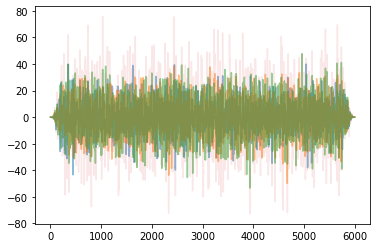

In [18]:
plt.plot(sample_E, alpha=0.5)
plt.plot(sample_N, alpha=0.5)
plt.plot(sample_Z, alpha=0.5)
plt.plot(sample_E + sample_N + sample_Z, alpha=0.1)

In [19]:
df_train = df_train.drop(['label','trace_id','E','N','Z','source_origin_time'],axis=1).dropna()
df_test = df_test.drop(['label','trace_id','E','N','Z','source_origin_time'],axis=1).dropna()

In [20]:
y_train = df_train['target'].values
y_test = df_test['target'].values

In [21]:
X_train = np.hstack((df_train[columns].values, meta_train_E, meta_train_N, meta_train_Z, meta_train_ENZ))
X_test = np.hstack((df_test[columns].values, meta_test_E, meta_test_N, meta_test_Z, meta_test_ENZ))
#X_train = np.hstack((meta_train_E, meta_train_N, meta_train_Z))
#X_test = np.hstack((meta_test_E, meta_test_N, meta_test_Z))

In [22]:
max_scalers = np.max(X_train, axis=0)
min_scalers = np.min(X_train, axis=0)

In [23]:
X_train = (X_train - min_scalers) / (max_scalers - min_scalers)

In [24]:
X_test = (X_test - min_scalers) / (max_scalers - min_scalers)

In [41]:
rf = RandomForestClassifier(max_depth=25, n_estimators=800, max_features=5, verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished


In [42]:
error_rate(y_test, y_pred)

0.22482131254061077

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cms = confusion_matrix(y_test, y_pred)

In [ ]:
test_score = np.trace(cms) / np.sum(cms)

In [ ]:
new_cms = np.zeros((7,7))
for x in range(7):
    for y in range(7):
        new_cms[x,y] = cms[x,y] / np.sum(cms[x])

In [ ]:
fig = plt.figure(figsize=(9, 9))
n_classes = 7
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(new_cms), interpolation="nearest", cmap="cool")
rows = cms.shape[0]
cols = cms.shape[1]
for x in range(0, rows):
    for y in range(0, cols):
        #value = int(cms[x, y])
        value = round(cms[x,y] / np.sum(cms[x])*100,1)
        ax.text(x, y, value, color="black", ha="center", va="center", fontsize=20)
plt.title("Real vs predicted data, accuracy: " + str(np.around(test_score*100, 1)) + "%", fontsize=20)
#plt.colorbar(im)

classes_values = []
#classes_labels = ["Noise", "SN he3pt5 model", "SN s18 model"]
classes_labels = classes

for n in range(n_classes):
    classes_values.append(n)
    #classes_labels.append(str(n))

#plt.xticks([0, 1, 2, 3, 4], ["0", "1", "2", "3", "4"], rotation=45, fontsize=25)
#plt.yticks([0, 1, 2, 3, 4], ["0", "1", "2", "3", "4"], fontsize=25)
plt.xticks(classes_values, classes_labels, rotation=45, fontsize=15)
plt.yticks(classes_values, classes_labels, fontsize=15)
plt.xlabel("Real data", fontsize=15)
plt.ylabel("Predicted data", fontsize=15)

In [ ]:
df_submission = pd.read_pickle('./data/df_submission.pkl.gzip', compression='gzip')

In [ ]:
trace_id = df_submission['trace_id'].values

In [ ]:
meta_sub_E = np.zeros((df_submission.shape[0], 5))
psd_sub_E = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_E = item['E']
    meta, psd, _ = get_meta(sample_E)
    meta_sub_E[i] = meta
    psd_sub_E[i] = psd
    i += 1

In [ ]:
meta_sub_N = np.zeros((df_submission.shape[0], 5))
psd_sub_N = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_N = item['N']
    meta, psd, _ = get_meta(sample_N)
    meta_sub_N[i] = meta
    psd_sub_N[i] = psd
    i += 1

In [ ]:
meta_sub_Z = np.zeros((df_submission.shape[0], 5))
psd_sub_Z = np.zeros((df_submission.shape[0], 513))
i = 0
for row, item in df_submission.iterrows():
    sample_Z = item['Z']
    meta, psd, _ = get_meta(sample_Z)
    meta_sub_Z[i] = meta
    psd_sub_Z[i] = psd
    i += 1

In [ ]:
df_submission = df_submission.drop(['trace_id','E','N','Z','source_origin_time'],axis=1).dropna()

In [ ]:
X_test_sub = np.hstack((df_submission[columns].values, meta_sub_E, meta_sub_N, meta_sub_Z))

In [ ]:
X_test_sub = (X_test_sub - min_scalers) / (max_scalers - min_scalers)

In [ ]:
y_pred_sb = rf.predict(X_test_sub)

In [ ]:
df_submit = pd.DataFrame({'trace_id' : trace_id,
                          'submission' : y_pred_sb})

In [ ]:
df_submit.head()

In [ ]:
df_submit.to_csv('./fm_ENZmeta_submission.csv',index=False)